# Device Failure Prediction using Machine Learning

--------------------------------------------------------------------

## Table of Contents

1. [Importing the Libraries](#import)
2. [Dataset Overview](#dataset-overview)
3. [Exploratory Data Analysis](#eda)
4. [Data Preprocessing](#preprocessing)
5. [Model Building](#model-building)
    1. [Logistic Regression](#LR)
    2. [Random Forest Classifier](#RF)
    3. [Extreme Gradient Boosting Classifier](#XGB)
    4. [K Nearest Neighbors Classifier](#KNN)
    5. [Gradient Boosting Classifier](#GB)
6. [Model Saving](#model-saving)
7. [Model Evaluation](#model-evaluation)
8. [Voting Classifier](#voting-classifier)
9. [Conclusion](#conclusion)

### 1. Importing the Libraries <a name = "import"></a>

In [163]:
# Importing the libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

In [196]:
# Creating a config class to store all the configurations
class config:
    
    # training dataset path
    DATASET_PATH = "../data/predict_failure.csv" 
    
    # Input parameters for data preprocessing
    TARGET = "failure"
    TEST_SIZE = 0.2
    SEED = 42
    N_SPLITS = 10
    
    # Input parameters for data samplking techniques
    SMOTE_SAMPLING_STRATERGY = 0.1
    UNDER_SAMPLING_STRATERGY = 0.75
    
    # Features to be dropped
    DROP_ATTRIBUTES = ["date", "device", "attribute7"]
    
    # List of features to be scaled based on Standardization/Normalization
    STANDARD_SCALER_ATTRIBUTES= ["attribute2", "attribute3", "attribute4", "attribute5", "attribute8", "attribute9"]
    MIN_MAX__SCALER_ATTRIBUTES = ["attribute1", "attribute6"]
    

### 2. Dataset Overview <a name = "dataset-overview"></a>

In [23]:
# Importing the dataset.
failure_data = pd.read_csv("../data/predict_failure.csv")
failure_data.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [3]:
# Shape of the dataset.
failure_data.shape

(124494, 12)

In [4]:
# Checking the dataset info.
failure_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [5]:
# Changing the date column type to datetime.
failure_data["date"] = pd.to_datetime(failure_data["date"], format="%Y-%m-%d")

In [6]:
# Checking for missing values
print(failure_data.isnull().sum()/len(failure_data)*100)

date          0.0
device        0.0
failure       0.0
attribute1    0.0
attribute2    0.0
attribute3    0.0
attribute4    0.0
attribute5    0.0
attribute6    0.0
attribute7    0.0
attribute8    0.0
attribute9    0.0
dtype: float64


In [7]:
# Checking the variations.
failure_data.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [8]:
# Checking for class imbalance based on target variable failure.
failure_data["failure"].value_counts()

0    124388
1       106
Name: failure, dtype: int64

### 3. Exploratory Data Analysis <a name = "eda"></a>

In [9]:
# Checking the unique number of devices in the dataset.
failure_data["device"].nunique()

1168

In [10]:
# Checking the most frequent devices in the dataset.
failure_data["device"].value_counts().head(10)

S1F0FGBQ    304
W1F0SJJ2    304
Z1F0GE1M    304
Z1F0KJDS    304
Z1F0KKN4    304
W1F0JY02    304
W1F0JXDL    304
W1F0JH87    304
S1F0E9EP    304
W1F0G9T7    304
Name: device, dtype: int64

In [11]:
# Printing the correlation between attributes.
failure_data.corr()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
failure,1.000000,0.001984,0.052902,-0.000948,0.067398,0.002270,-0.000550,0.119055,0.119055,0.001622
attribute1,0.001984,1.000000,-0.004248,0.003702,0.001837,-0.003370,-0.001516,0.000151,0.000151,0.001122
attribute2,0.052902,-0.004248,1.000000,-0.002617,0.146593,-0.013999,-0.026350,0.141367,0.141367,-0.002736
attribute3,-0.000948,0.003702,-0.002617,1.000000,0.097452,-0.006696,0.009027,-0.001884,-0.001884,0.532366
attribute4,0.067398,0.001837,0.146593,0.097452,1.000000,-0.009773,0.024870,0.045631,0.045631,0.036069
attribute5,0.002270,-0.003370,-0.013999,-0.006696,-0.009773,1.000000,-0.017051,-0.009384,-0.009384,0.005949
attribute6,-0.000550,-0.001516,-0.026350,0.009027,0.024870,-0.017051,1.000000,-0.012207,-0.012207,0.021152
attribute7,0.119055,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.006861
attribute8,0.119055,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.006861
attribute9,0.001622,0.001122,-0.002736,0.532366,0.036069,0.005949,0.021152,0.006861,0.006861,1.000000


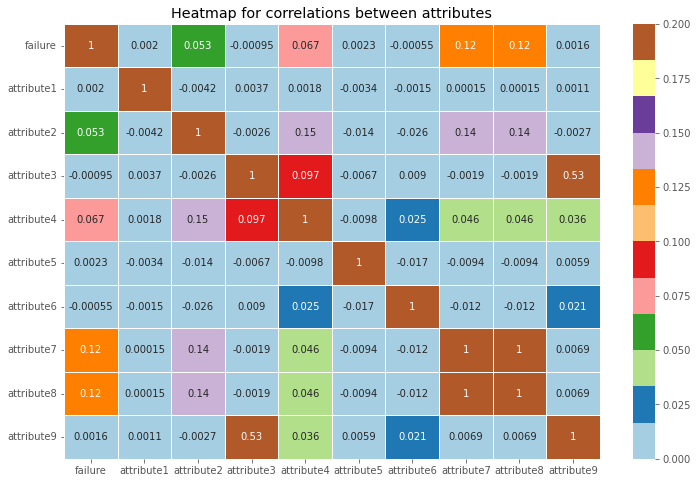

In [12]:
# Visualizing the correlations between attributes using heatmap.
plt.figure(figsize=(12, 8))
sns.heatmap(failure_data.corr(), cmap="Paired", annot=True, vmin=0, vmax=0.2, linewidths=1)
plt.title("Heatmap for correlations between attributes")
plt.show()

We can see from the correlation chart that attributes 7 and attribute have a correlation of 1 which means they are same. Also, there's not much correlation between the rest of them.

In [13]:
# Looks like attribute 7 and attribute 8 are similar. Let's confirm the same.
failure_data["attribute7"].equals(failure_data["attribute8"])

True

In [14]:
# Creating a seperate dataframe for records when the device has failed.
failures = failure_data[failure_data["failure"]== 1]

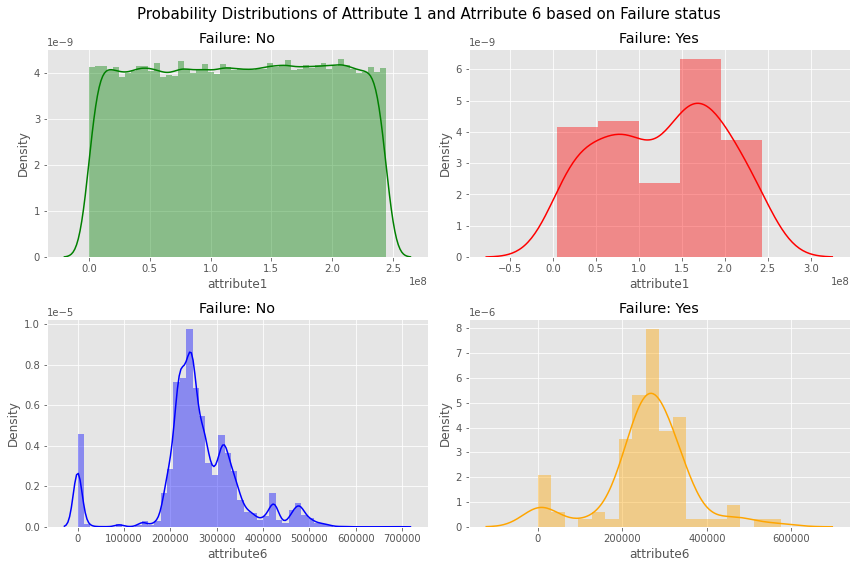

In [15]:
# Plotting a distplot to see the distribution of attribute 1 and attribute 6.
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=False, sharex=False)
fig.suptitle('Probability Distributions of Attribute 1 and Atrribute 6 based on Failure status', fontsize=15)

sns.distplot(ax=axes[0, 0], a=failure_data[failure_data["failure"]==0]["attribute1"], color = "green")
axes[0, 0].set_title("Failure: No")
sns.distplot(ax=axes[0, 1], a=failure_data[failure_data["failure"]== 1]["attribute1"], color="red")
axes[0, 1].set_title("Failure: Yes")
sns.distplot(ax=axes[1, 0], a=failure_data[failure_data["failure"]==0]["attribute6"], color = "blue")
axes[1, 0].set_title("Failure: No")
sns.distplot(ax=axes[1, 1], a=failure_data[failure_data["failure"]== 1]["attribute6"], color="orange")
axes[1, 1].set_title("Failure: Yes")
fig.tight_layout()
plt.show()


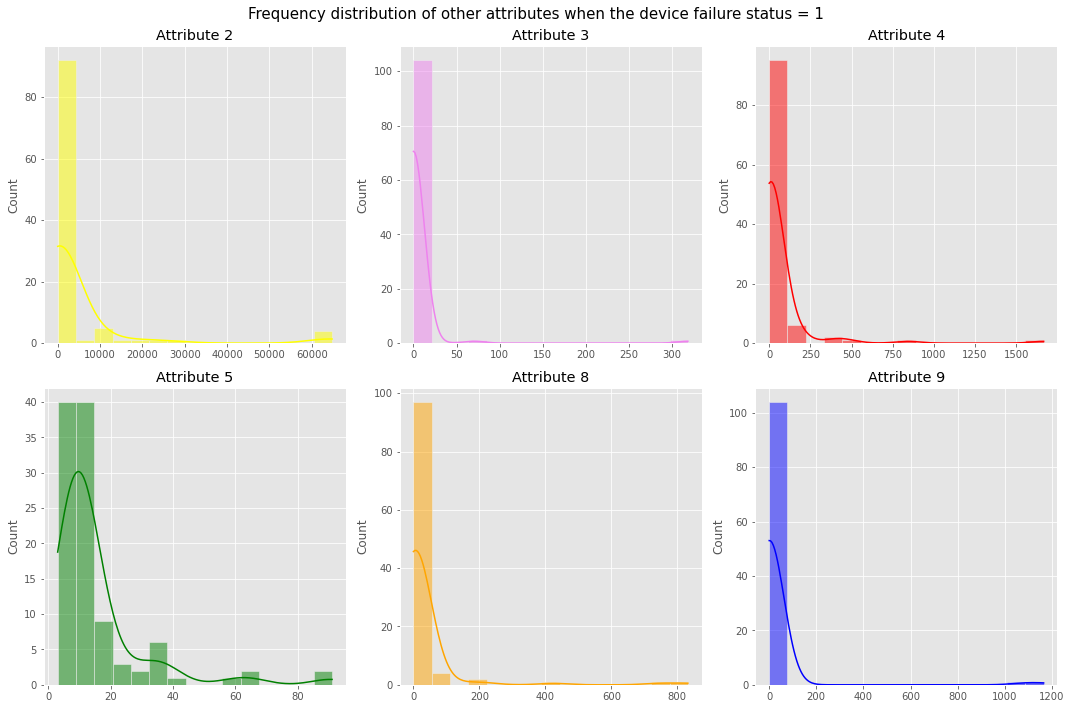

In [17]:
# Checking probability distributions for attributes 2, 3, 4, 5, 8 and 9 when failure is 1.
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=False, sharex=False)
fig.suptitle('Frequency distribution of other attributes when the device failure status = 1', fontsize=15)

sns.histplot(ax=axes[0, 0], data=failures,x="attribute2", kde=True, bins=15, color="yellow")
axes[0, 0].set_title("Attribute 2")
axes[0, 0].set_xlabel(None)
sns.histplot(ax=axes[0, 1], data=failures, x="attribute3", kde=True, bins=15, color="violet")
axes[0, 1].set_title("Attribute 3")
axes[0, 1].set_xlabel(None)
sns.histplot(ax=axes[0, 2], data=failures, x="attribute4", kde=True, bins=15, color="red")
axes[0, 2].set_title("Attribute 4")
axes[0, 2].set_xlabel(None)
sns.histplot(ax=axes[1, 0], data=failures, x="attribute5", kde=True, bins=15, color="green")
axes[1, 0].set_title("Attribute 5")
axes[1, 0].set_xlabel(None)
sns.histplot(ax=axes[1, 1], data=failures, x="attribute8", kde=True, bins=15, color="orange")
axes[1, 1].set_title("Attribute 8")
axes[1, 1].set_xlabel(None)
sns.histplot(ax=axes[1, 2], data=failures,x="attribute9", kde=True, bins=15, color="blue")
axes[1, 2].set_title("Attribute 9")
axes[1, 2].set_xlabel(None)
fig.tight_layout()
plt.show()

Looks like only the attribute1 and attribute6 from our given dataset are normally distributed. But the rest of the attributes don't have a valid distribution as the data is skewed. But, if we take a look at the boxplot of these attributes to check for outliers, there are just too many for them to be removed. They could be useful features for detecting device failures, so we are just going to keep them all. Also, since all the attributes are of different scales, we can fix that by performing Standardization and Normalization.

In [16]:
# Let's check out the date column in more detail.
failure_data["date"].nunique()

304

In [17]:
# Checking the earliest and latest date available in our dataset.
print("Earliest date: ",failure_data["date"].min())
print("Latest date: ",failure_data["date"].max())

Earliest date:  2015-01-01 00:00:00
Latest date:  2015-11-02 00:00:00


In [25]:
# Assuming we have records of device from the day it was set up, creating a device uptime (in days) column.
failure_data.sort_values(by=["device", "date"], inplace=True)
failure_data["device_uptime"] = failure_data.groupby(by="device")["date"].rank(method="dense")

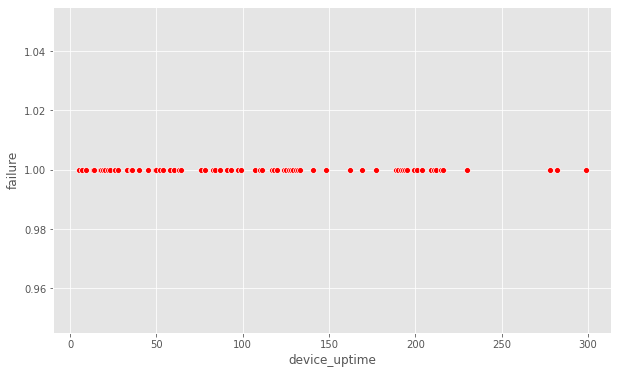

In [19]:
# Checking the frequency of device failures based on their uptime
plt.figure(figsize=(10, 6))
sns.lineplot(data=failure_data[failure_data["failure"] == 1], x="device_uptime", y="failure", marker="o", linestyle='', color="red")
plt.show()

In [26]:
# Looks like there is not much of correlation between the uptime and failure of devices.
# Also, assuming here that devices are of the same type. 
# Dropping the non-required columns from our dataset.
failure_data.drop(["attribute7", "device", "device_uptime", "date"], axis=1, inplace=True)
failure_data.head(5)

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute8,attribute9
0,0,215630672,56,0,52,6,407438,0,7
1163,0,1650864,56,0,52,6,407438,0,7
2326,0,124017368,56,0,52,6,407438,0,7
3489,0,128073224,56,0,52,6,407439,0,7
4651,0,97393448,56,0,52,6,408114,0,7


### 4. Data Preprocessing <a name = "preprocessing"></a>

In [27]:
# Creating array of independent variables and target.
X = failure_data.drop("failure", axis=1)
y = failure_data.iloc[:, 0]
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

Shape of X:  (124494, 8)
Shape of y:  (124494,)


In [28]:
# Splitting the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 99510, 1: 85})
Counter({0: 24878, 1: 21})


Our dataset is severely imbalanced and to tackle this issue, we'll be using SMOTE for oversampling followed by random undersampling to get the right amount of data for training our model.

In [29]:
# Creating a SMOTE based sampler.
smote = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.75)

In [30]:
# Creating an imblearn pipeline to perform SMOTE followed by undersampling
from imblearn.pipeline import Pipeline
sampling_pipeline = Pipeline([
    ("smote", smote),
    ("under_sampling", under)
])

In [31]:
# Resampling the training dataset to tackle imbalance problem
X_train_rs, y_train_rs = sampling_pipeline.fit_resample(X_train, y_train)
print("Number of training samples before resampling: ", Counter(y_train))
print("Number of training samples after resampling: ", Counter(y_train_rs))

Number of training samples before resampling:  Counter({0: 99510, 1: 85})
Number of training samples after resampling:  Counter({0: 13268, 1: 9951})


In [32]:
# Making a list of attributes that needs to be scaled via normalization/standardization.
std_attributes = ["attribute2", "attribute3", "attribute4", "attribute5", "attribute8", "attribute9"]
min_max_attributes = ["attribute1", "attribute6"]

In [34]:
# Building a columntransformer pipeline for data preprocessing
preprocessing_pipeline = ColumnTransformer([
    ("std_scaler", StandardScaler(), std_attributes),
    ("min_max_scaler", MinMaxScaler(), min_max_attributes)
])

### 5. Model Building <a name = "model-building"></a>

Since our test dataset is highly imbalanced ie. the chances of failure are less, evaluating the model based on accuracy is not a good idea. Instead, we'll be focusing on the ROC-AUC curve as a performance metric when it comes to solving our problem. Also, an output in the form of probability is required by the team.

In [33]:
# create a Stratified K_fold split
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [35]:
# Creating a function to display scores
def display_scores(scores):
    print("ROC-AUC Scores: ", scores)
    print("ROC-AUC Mean: ", scores.mean())
    print("ROC-AUC SD: ", scores.std())

In [36]:
# a function to print all metrics of results on test set
def print_metrics(prediction):
    print("Accuracy: ", round(accuracy_score(y_test, prediction), 2))
    print("ROC-AUC score: ", round(roc_auc_score(y_test, prediction), 2))
    print("F1-score: ", round(f1_score(y_test, prediction, average="macro"), 2))
    print("Precision: ", round(precision_score(y_test, prediction, average="macro"), 2))
    print("Recall: ", round(recall_score(y_test, prediction, average="macro"), 2))
    print("---------------------------")
    print(confusion_matrix(y_test, prediction))
    print("---------------------------")
    print(classification_report(y_test, prediction))

#### 5.1 Logistic Regression <a name = "LR"></a>

In [194]:
# Let's first build a Simple Logistic regression Model
lr_pipeline = Pipeline([
    ("preprocess", StandardScaler()),
    ("lr", LogisticRegression(solver="saga", max_iter=1000, class_weight="balanced"))
])

scores = cross_val_score(lr_pipeline, X_train_rs, y_train_rs, scoring="roc_auc", cv=cv)

In [195]:
# Checking out the scores for our Logistic Regression Model
display_scores(scores)

ROC-AUC Scores:  [0.91379126 0.89983754 0.91252192 0.90243304 0.89807818 0.90417574
 0.91410027 0.91119653 0.90238783 0.91200346]
ROC-AUC Mean:  0.9070525766031791
ROC-AUC SD:  0.0059215674852855765


In [39]:
# Create a param_grid with values for tuning hyperparameters
lr_param_grid = [{'lr__solver': ['newton-cg', 'lbfgs', 'saga', 'sag'], 'lr__penalty' : ['none', 'l1', 'l2', 'elasticnet'], 
                    'lr__C' : 10.0 **np.arange(-2,3)}]

In [ ]:
# Creating a gridsearchCV for Logistic Regression model
lr_pipeline = Pipeline([
    ("preprocess", StandardScaler()),
    ("lr", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=cv, scoring="roc_auc", return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_rs, y_train_rs)

In [41]:
# checking the model's best performing hyperparameters
grid_search.best_params_

{'lr__C': 0.01, 'lr__penalty': 'l1', 'lr__solver': 'saga'}

In [42]:
# checking the model's best score
grid_search.best_score_

0.9107042924605169

In [43]:
# Selecting the model with best parameters
final_lr_model = grid_search.best_estimator_

# Checking the model performance on test data
y_pred_lr = final_lr_model.predict(X_test)
print_metrics(y_pred_lr)

Accuracy:  0.97
ROC-AUC score:  0.8
F1-score:  0.51
Precision:  0.51
Recall:  0.8
---------------------------
[[24191   687]
 [    8    13]]
---------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     24878
           1       0.02      0.62      0.04        21

    accuracy                           0.97     24899
   macro avg       0.51      0.80      0.51     24899
weighted avg       1.00      0.97      0.99     24899



#### 5.2 Random Forest Classifier <a name = "RF"></a>

In [44]:
# Let's now build a Random Forest classifier Model
rf_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("rf", RandomForestClassifier(n_estimators=200, class_weight="balanced"))
])

scores = cross_val_score(rf_pipeline, X_train_rs, y_train_rs, scoring="roc_auc", cv=cv)

In [45]:
# Checking out the scores for our Random Forest Model
display_scores(scores)

ROC-AUC Scores:  [0.99973113 0.99985421 0.99951945 0.99949029 0.99950393 0.9996713
 0.9997815  0.99972621 0.99959226 0.99965135]
ROC-AUC Mean:  0.9996521634588769
ROC-AUC SD:  0.00011790417941894849


In [59]:
# Create a param_grid with values for tuning hyperparameters
rf_param_grid = [{'rf__criterion': ["gini", "entropy"], 'rf__n_estimators': [100, 200], 
               'rf__max_depth': [10, 12], 'rf__max_features': [7, 8]}]

In [ ]:
# Creating a gridsearchCV for randomforestModel
rf_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("rf", RandomForestClassifier(class_weight="balanced") )
])

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=cv, scoring="roc_auc", return_train_score=True, n_jobs=-1)
rf_grid_search.fit(X_train_rs, y_train_rs)

In [64]:
# checking the model's best performing hyperparameters
rf_grid_search.best_params_

{'rf__criterion': 'entropy',
 'rf__max_depth': 12,
 'rf__max_features': 7,
 'rf__n_estimators': 100}

In [65]:
# checking the model's best score
rf_grid_search.best_score_

0.998804953403724

In [66]:
# Selecting the model with best parameters
final_rf_model = rf_grid_search.best_estimator_

# Checking the model performance on test data
y_pred_rf = final_rf_model.predict(X_test)
print_metrics(y_pred_rf)

Accuracy:  0.98
ROC-AUC score:  0.63
F1-score:  0.51
Precision:  0.51
Recall:  0.63
---------------------------
[[24422   456]
 [   15     6]]
---------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     24878
           1       0.01      0.29      0.02        21

    accuracy                           0.98     24899
   macro avg       0.51      0.63      0.51     24899
weighted avg       1.00      0.98      0.99     24899



#### 5.3 Extreme Gradient Boosting Classifier <a name = "XGB"></a>

In [110]:
# Finally, Let's try out the XGboost Classifier
xgb_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("xgb", XGBClassifier(n_estimators=1100, learning_rate = 0.001))
])

#scores = cross_val_score(xgb_pipeline, X_train_rs, y_train_rs, scoring="roc_auc", cv=cv)

In [106]:
display_scores(scores)

ROC-AUC Scores:  [0.99559629 0.99696296 0.99534598 0.99542513 0.99502297 0.99511423
 0.99727954 0.99643356 0.99513173 0.99713234]
ROC-AUC Mean:  0.9959444742989959
ROC-AUC SD:  0.000861285393778778


In [ ]:
# Fitting the pipeline on the training data
xgb_pipeline.fit(X_train_rs, y_train_rs)

In [112]:
# Checking the model performance on test data
y_pred_xgb = xgb_pipeline.predict(X_test)
print_metrics(y_pred_xgb)

Accuracy:  0.95
ROC-AUC score:  0.81
F1-score:  0.5
Precision:  0.51
Recall:  0.81
---------------------------
[[23705  1173]
 [    7    14]]
---------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     24878
           1       0.01      0.67      0.02        21

    accuracy                           0.95     24899
   macro avg       0.51      0.81      0.50     24899
weighted avg       1.00      0.95      0.97     24899



#### 5.4 K Nearest Neighbors Classifier <a name = "KNN"></a>

In [133]:
# Let's first build a K Nearerst Neigbors classifier Model
knn_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("knn", KNeighborsClassifier(n_neighbors=25))
])

scores = cross_val_score(knn_pipeline, X_train_rs, y_train_rs,scoring="roc_auc", cv=cv)

In [134]:
# Checking out the scores for our K Nearest Neigbors Model
display_scores(scores)

ROC-AUC Scores:  [0.9868347  0.98860807 0.98805671 0.98654349 0.98698201 0.98775111
 0.99105664 0.98736751 0.98685731 0.9864549 ]
ROC-AUC Mean:  0.987651245894529
ROC-AUC SD:  0.001310359941735822


In [ ]:
# Fitting the pipeline on the training data
knn_pipeline.fit(X_train_rs, y_train_rs)

In [185]:
# Checking the model performance on test data
y_pred_knn = knn_pipeline.predict(X_test)
print_metrics(y_pred_knn)

Accuracy:  0.94
ROC-AUC score:  0.85
F1-score:  0.5
Precision:  0.51
Recall:  0.85
---------------------------
[[23427  1451]
 [    5    16]]
---------------------------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     24878
           1       0.01      0.76      0.02        21

    accuracy                           0.94     24899
   macro avg       0.51      0.85      0.50     24899
weighted avg       1.00      0.94      0.97     24899



#### 5.5 Gradient Boosting Classifier <a name = "GB"></a>

In [159]:
# Let's first build a GradientBoosting classifier Model
gb_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("gb", GradientBoostingClassifier(n_estimators=100, learning_rate = 0.01))
])

scores = cross_val_score(gb_pipeline, X_train_rs, y_train_rs,scoring="roc_auc", cv=cv)

In [160]:
# Checking out the scores for our K Nearest Neigbors Model
display_scores(scores)

ROC-AUC Scores:  [0.96488244 0.95967744 0.96754685 0.95979786 0.95662449 0.95966949
 0.96859315 0.96561368 0.95814745 0.96581171]
ROC-AUC Mean:  0.9626364555141805
ROC-AUC SD:  0.0040681200111274


In [ ]:
# Fitting the pipeline on the training data
gb_pipeline.fit(X_train_rs, y_train_rs)

In [184]:
# Checking the model performance on test data
y_pred_gb = gb_pipeline.predict(X_test)
print_metrics(y_pred_gb)

Accuracy:  0.94
ROC-AUC score:  0.87
F1-score:  0.49
Precision:  0.51
Recall:  0.87
---------------------------
[[23348  1530]
 [    4    17]]
---------------------------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     24878
           1       0.01      0.81      0.02        21

    accuracy                           0.94     24899
   macro avg       0.51      0.87      0.49     24899
weighted avg       1.00      0.94      0.97     24899



As, we can see from the above results, Logistic Regression and Random Forest Classifier perform better when it comes to False positives, but RF fails when it comes to the True positives. On the contrary, XGboost Classifier, K Nearest Neighbors Classifier and Gradient Boosting perform really well for detecting the probability of device failures but fails severely because of the number of False Positives with a ROC-AUC Score of 0.81, 0.85 and 0.87 respectively. For this problem, I am assuming that predicting the true negative is also important since these devices can be still used without any worry. But more importantly, predicting the device failures i.e true positive is critical.

### 6. Model Saving <a name = "model-saving"></a>

In [192]:
# Saving all the ML models
import joblib

# Logistic Regression Model
joblib.dump(final_lr_model, "../models/logistic_regression_failure.pkl")

# Random Forest Classifier Model
joblib.dump(final_rf_model, "../models/random_forest_failure.pkl")

# K Nearest Neigbors Classifier Model
joblib.dump(knn_pipeline, "../models/k_nearest_neighborsfailure.pkl")

#Gradient Boosting Classifier Model
joblib.dump(gb_pipeline, "../models/gradient_boosting_failure.pkl")

# Extreme Gradient Boosting Classifier Model
joblib.dump(xgb_pipeline, "../models/xtreme_boosting_failure.pkl")

['../models/xtreme_boosting_failure.pkl']

### 7. Model Evaluation <a name = "model-evaluation"></a>

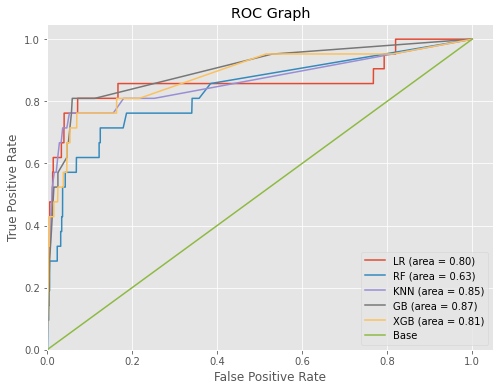

In [191]:
# Create ROC Graph
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, final_lr_model.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, final_rf_model.predict_proba(X_test)[:,1])
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_pipeline.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_pipeline.predict_proba(X_test)[:,1])
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, gb_pipeline.predict_proba(X_test)[:,1])

lr_roc_auc = roc_auc_score(y_test, y_pred_lr)
rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
knn_roc_auc = roc_auc_score(y_test, y_pred_knn)
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb)
gb_roc_auc = roc_auc_score(y_test, y_pred_gb)

plt.figure(figsize=(8, 6))

# Plot Logistic Regression ROC
plt.plot(lr_fpr, lr_tpr, label='LR (area = %0.2f)' % lr_roc_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='RF (area = %0.2f)' % rf_roc_auc)

# Plot K Nearest Neighbors ROC
plt.plot(knn_fpr, knn_tpr, label='KNN (area = %0.2f)' % knn_roc_auc)

# Plot Gboost ROC
plt.plot(gb_fpr, gb_tpr, label='GB (area = %0.2f)' % gb_roc_auc)

# Plot XGboost ROC
plt.plot(xgb_fpr, xgb_tpr, label='XGB (area = %0.2f)' % xgb_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base')

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

### 8. Voting Classifier <a name = "voting-classifier"></a>

Since the models trained by us are lacking in some parts (either TP or FP) when it comes to predicting the failure of devices, we will ensemble three of our top performing models using a Voting classifier. This will help us reduce the number of FP and increase the TP.

In [ ]:
# Creating a Voting Classifier consisting of our top 3 performing models i.e GB, LR and KNN Classifiers
vc_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("v_clf", VotingClassifier(estimators=[("gb", GradientBoostingClassifier(n_estimators=500, learning_rate = 0.01)),
                                               ("knn", KNeighborsClassifier(n_neighbors=25)),
                                                ("lr", LogisticRegression(solver="saga", max_iter=1000, class_weight="balanced"))],
                                voting="soft"))
])

vc_pipeline.fit(X_train_rs, y_train_rs)

In [234]:
# Checking the model performance on test data
y_pred_vc = vc_pipeline.predict(X_test)
print_metrics(y_pred_vc)

Accuracy:  0.96
ROC-AUC score:  0.89
F1-score:  0.51
Precision:  0.51
Recall:  0.89
---------------------------
[[23978   900]
 [    4    17]]
---------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     24878
           1       0.02      0.81      0.04        21

    accuracy                           0.96     24899
   macro avg       0.51      0.89      0.51     24899
weighted avg       1.00      0.96      0.98     24899



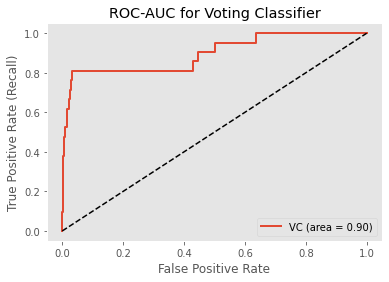

In [241]:
# Computing the TPR and FPR values from the roc curve
y_pred =  vc_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
# Plotting the ROC curve
def plot_roc_curve (fpr, tpr, label = None, title=None):
    plt.plot(fpr, tpr, linewidth = 2, label= label)
    plt.plot([0,1], [0,1], 'k--') # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(title)
    plt.grid()
    plt.legend(loc="lower right")
    
plot_roc_curve(fpr, tpr, 'VC (area = %0.2f)' % roc_auc, "ROC-AUC for Voting Classifier")
plt.show()

In [242]:
# This looks great. We'll go ahead and save this as our final model
joblib.dump(vc_pipeline, "../models/final_voting_classifier_model.pkl")

['../models/final_voting_classifier_model.pkl']

### 9. Conclusion <a name = "conclusion"></a>

To conclude, we have implemented an ensemble of trained Machine Learning models such as Logistic Regression, Gradient Boosting Classifier and K Nearest Neighbors using Voting Classifier to predict the probabilty of device failures given some input features. The ensemble model acheievd an ROC-AUC score of almost 0.90 on the unseen test data.

# Thank you!